In [1]:
#default_exp train_adjacent

In [2]:
#export
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *

Loading imports


In [3]:
column='SeriesInstanceUID'

In [4]:
df_series = Meta.df_any.sort_values(['SeriesInstanceUID', "ImagePositionPatient2"])

In [5]:
df_series

,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,Rows,...,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
SOPInstanceUID,,,,,,,,,,,,,,,,,,,,,
ID_4509f2560,CT,ID_4c16e232,ID_c174374b07,ID_002c9733b7,,-125.0,1.0,1,MONOCHROME2,512,...,1.0,40.0,1.0,80.0,0,0,0,0,0,0
ID_0969176c0,CT,ID_4c16e232,ID_c174374b07,ID_002c9733b7,,-125.0,1.0,1,MONOCHROME2,512,...,1.0,40.0,1.0,80.0,0,0,0,0,0,0
ID_2363aa3ef,CT,ID_4c16e232,ID_c174374b07,ID_002c9733b7,,-125.0,1.0,1,MONOCHROME2,512,...,1.0,40.0,1.0,80.0,0,0,0,0,0,0
ID_7b6119ddf,CT,ID_4c16e232,ID_c174374b07,ID_002c9733b7,,-125.0,1.0,1,MONOCHROME2,512,...,1.0,40.0,1.0,80.0,0,0,0,0,0,0
ID_a787384c2,CT,ID_4c16e232,ID_c174374b07,ID_002c9733b7,,-125.0,1.0,1,MONOCHROME2,512,...,1.0,40.0,1.0,80.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_8eb7c45bc,CT,ID_984a3f15,ID_7891a70bf4,ID_fffde5ed33,,-125.0,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
ID_cf66e9f08,CT,ID_984a3f15,ID_7891a70bf4,ID_fffde5ed33,,-125.0,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
ID_6c779d850,CT,ID_984a3f15,ID_7891a70bf4,ID_fffde5ed33,,-125.0,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0


In [6]:
fn = get_pil_fn(path_jpg256)

In [7]:
sop = 'ID_0969176c0'
idx = df_series.index.get_loc(sop)

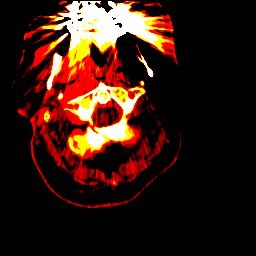

In [8]:
img = fn(sop)
img

In [9]:
# sid = df_series.loc[sop].SeriesInstanceUID
# prev_row = df_series.iloc[idx-1]
# prev_item = df_series.index[idx-1]
# prev_row

# tt = ToTensor()

# # if prev_row.SeriesInstanceUID == sid:
# prev = tt(fn(prev_item))

In [10]:
df_series.shape[0]-1

300933

In [11]:
#export
class TfmSlice:
    def __init__(self, df, path, c3=False): 
        self.fn = get_pil_fn(path)
        self.tt = ToTensor()
        self.df = df
        self.c3 = c3
        
    def get_adj(self, idx, x_mid, sid_mid):
        if idx < 0 or idx >= self.df.shape[0] \
        or  self.df.iloc[idx].SeriesInstanceUID != sid_mid:
            return torch.zeros_like(x_mid)
        adj_item = self.df.index[idx]
        return self.tt(self.fn(adj_item))
        
    def __call__(self, item):
        idx = self.df.index.get_loc(item)
        sid = self.df.loc[item].SeriesInstanceUID
        x = self.tt(self.fn(item))
        x_prev = self.get_adj(idx-1, x, sid)
        x_next = self.get_adj(idx+1, x, sid)
        x = x[:1] if self.c3 else x
        
        return TensorCTScan(torch.cat([x_prev[:1], x, x_next[:1]]))

In [12]:
tfm = TfmSlice(df_series, path_jpg256)

In [13]:
tfm(sop).shape

torch.Size([5, 256, 256])

In [14]:
tfm = TfmSlice(df_series, path_jpg256, c3=True)

In [15]:
tfm(sop).shape

torch.Size([3, 256, 256])

In [16]:
#export
def get_adj_dsrc(df, path=path_jpg256, grps=Meta.grps, cv_idx=0, column='SeriesInstanceUID',
               pad_to=None, c3=False):
    df_series = df.sort_values(['SeriesInstanceUID', "ImagePositionPatient2"])
    tfm = TfmSlice(df_series, path, c3=c3)
    sops = df_series.index.unique()
    splits_series = split_data(df_series, 0, grps, 'SeriesInstanceUID')
    dsrc = DataSource(sops, [[tfm],[fn2label,EncodedMultiCategorize(htypes)]], splits=splits_series)
    return dsrc

In [17]:
dsrc = get_adj_dsrc(Meta.df_any)

In [18]:
dsrc[10][0].shape

torch.Size([5, 256, 256])

In [19]:
x,y = dsrc[10]

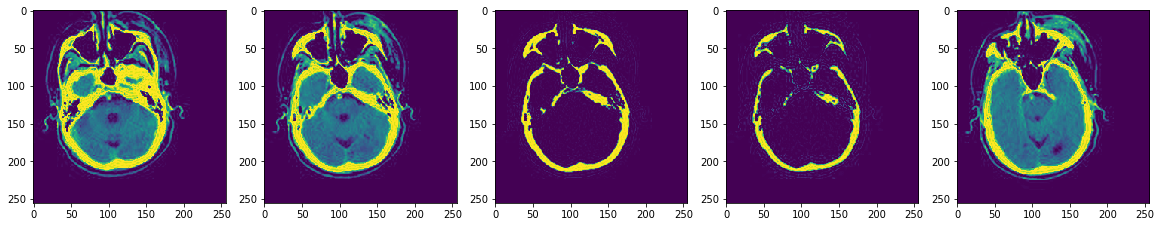

In [20]:
f, ax = plt.subplots(1,5,figsize=(20,20))
for idx,c in enumerate(x):
    ax[idx].imshow(c)

In [21]:
#export
mean_5c = [mean[0], *mean, mean[0]]
std_5c = [std[0], *std, std[0]]

mean_adj = [mean[0]]*3
std_adj = [mean[0]]*3

In [22]:
#export
def get_data_gen(df, grps, bs, sz=None, nw=8, wgts=None, batch_xtra=None, after_item=None, with_aug=True, test=False, 
                 c3=False, **kwargs):
#     tfms = [[img_tfm, ToTensor], [fn2label,EncodedMultiCategorize(htypes)]]
#     if test: tfms = [tfms[0]]
    stats = (mean_adj, std_adj) if c3 else (mean_5c, std_5c)
    dsrc = get_adj_dsrc(Meta.df_any, grps=grps, c3=c3)
    nrm = Normalize.from_stats(*stats)
    batch_tfms = L(IntToFloatTensor, nrm, Cuda()) + L(batch_xtra)
    if with_aug: batch_tfms += aug_transforms(**kwargs)
    if sz is not None:
        batch_tfms = batch_tfms+[RandomResizedCropGPU(sz, min_scale=0.7, ratio=(1.,1.), valid_scale=0.9)]
    if wgts is None:
        return dsrc.databunch(bs=bs, num_workers=nw, after_item=after_item, after_batch=batch_tfms)
    else:
        return dsrc.weighted_databunch(wgts, bs=bs, num_workers=nw, after_item=after_item, after_batch=batch_tfms)


## Train

In [24]:
dbunch = get_data_gen(Meta.df_any, Meta.grps_any, 512, sz=128)

In [25]:
learn = get_learner(dbunch, partial(xresnet18, c_in=5))

In [ ]:
do_fit(learn, 1, 4e-2)

## Export

In [27]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_metadata.ipynb.
Converted 01_preprocess.ipynb.
Converted 01_preprocess_mean_std.ipynb.
Converted 02_train.ipynb.
Converted 03_train3d.ipynb.
Converted 03_train3d_01_train3d.ipynb.
Converted 03_train3d_02_train_head.ipynb.
Converted 04_trainSeq_01_lstm.ipynb.
Converted 04_trainSeq_02_transformer.ipynb.
Converted 05_train_adjacent.ipynb.
Converted 05_train_adjacent_01_5c.ipynb.
Converted 05_train_adjacent_02_3c.ipynb.
